# Source Code Analysis

## Initialization

In [1]:
import os
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)
        sys.path.append(path)    
add_path('/home/jjian03/anaconda3/lib/python3.7/site-packages')
add_path(f'{os.path.abspath(os.path.join("."))}/lib')


### Load Data

In [2]:
from lib.Repository import *
from lib.Utility import *
from lib.modeling import *
from lib.preprocessing import *
from lib.preprocessing.HTMLParser import html_parser
from lib.viz import *

Allocated 16 CPUs


In [3]:
import time
import datetime
start_time = time.time()
raw_data = DataSource(job_name='lasso_truncated', cache_name = 'trunc_data.csv', truncated=True, fract=.04).raw_data

raw_data.info()

print(f'raw_data: {shape(raw_data)}')

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

Sample Size - raw_data: 14673
Initialized
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14673 entries, 0 to 14672
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      14673 non-null  object 
 1   url                                     14673 non-null  object 
 2   actual_scrape_url                       14673 non-null  object 
 3   first_appear                            14673 non-null  int64  
 4   first_available_timestamp               0 non-null      float64
 5   last_available_timestamp                14673 non-null  int64  
 6   header                                  14673 non-null  object 
 7   html_text                               14673 non-null  object 
 8   comment                                 14673 non-null  object 
 9   from_waybackmachine                     14673 non-null  int64  
 10  http_status_code

### Train Test Split

In [4]:
start_time = time.time()

train_data = DataSource().train_data
test_data = DataSource().test_data


print('Shape of the dataframe:')
print(f'train_data: {shape(train_data)}')
print(f'test_data: {len(test_data)}')

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

Shape of the dataframe:
train_data: (10271, 36)
test_data: 4402
--- 00 minutes, 0.00 seconds ---


In [5]:
display(pd.DataFrame({
    'unique count': print_unique_count(train_data),
    'na count': print_na_count(train_data)
}, index=train_data.columns))

unique count  na count
id                                              9828         0
url                                             9828         0
actual_scrape_url                               9804         0
first_appear                                      22         0
first_available_timestamp                          1     10271
last_available_timestamp                        9799         0
header                                          9828         0
html_text                                       7164         0
comment                                         2243         0
from_waybackmachine                                2         0
http_status_code                                   1         0
original_check_failure                             2         0
original_check_error_log                          36         0
terminate_reason                                   1         0
terminate_reason_error_log                         1         0
paperId                                         9447         0
total_num_of_paper_citing                        258       306
total_num_of_author_citing                      1087       306
total_num_of_affiliation_citing                  423       389
total_num_of_journal_citing                      246       347
total_num_of_author_self_citation                 60      2805
total_num_of_affiliation_self_citation            59      4013
total_num_of_journal_self_citation                35      5672
avg_year                                        5907       306
min_year                                         179       306
max_year                                          36       306
median                                            50      5283
num_of_author                                     68      2021
num_of_author_citing                             932       306
num_of_affiliation_citing                        291       389
num_of_journal_citing                            136       347
avg_hindex                                      1521       197
first_author_hindex                               96      1478
last_author_hindex                               135         0
avg_mid_author_hindex                           1293      1881
paper_unique_affiliation                          38      2021

## Modeling

### Elastic Net Regression

#### 1st Edition - Combine suffix dummy with MAG

In [6]:
from feature_engine import categorical_encoders


pipe = Pipeline([
    ('label_builder', LabelBuilder()),
    ('url_parser', URLParser()),
    ('url_length_counter', URLLengthCounter()),
    ('url_depth_counter', URLDepthCounter()),
    ('has_www_converter', HasWWWConverter()),
    ('subdomain_level_counter', SubdomainLevelCounter()),
    ('request_parameter_counter', RequestParameterCounter()),
    ('domain_suffix_builder', DomainSuffixBuilder()),
    ('incorrect_domain_url_cleaner', IncorrectDomainUrlCleaner()),
    ('column_renamer', ColumnRenamer({'scheme': 'protocol_type'})),
    ('binary_na_encoder', BinaryNAEncoder(['content_type'])),
    ('html_parser', html_parser),
    ('binary_feature_converter', FeatureValueMapper('protocol_type', {
                                        'http': 1,
                                        'https':0,
                                        })),

    ('nan_to_Zero_converter', NanToZeroConverter([
        'total_num_of_paper_citing',
        'total_num_of_author_citing',
        'total_num_of_affiliation_citing',
        'total_num_of_journal_citing',
        'total_num_of_author_self_citation',
        'total_num_of_affiliation_self_citation',
        'total_num_of_journal_self_citation',
        'avg_year',
        'min_year',
        'max_year',
        'median',
        'num_of_author',
        'num_of_author_citing',
        'num_of_affiliation_citing',
        'num_of_journal_citing',
        'avg_hindex',
        'first_author_hindex',
        'last_author_hindex',
        'avg_mid_author_hindex',
        'paper_unique_affiliation'
    ])),
    
    ('feature_picker', FeaturePicker([
                                        'protocol_type',
                                        'url_depth',
                                        'has_www',
                                        'subdomain_level',
                                        'param_cnt',
                                        'suffix_idx',
                                        'is_port_access',
                                        'code_size',
                                        'title_length',
                                        'internal_js_cnt',
                                        'external_js_cnt',
                                        'charset',
                                        'is_html5',
                                        'has_iframe',
                                        'hyperlink_cnt',

                                        'total_num_of_paper_citing',
                                        'total_num_of_author_citing',
                                        'total_num_of_affiliation_citing',
                                        'total_num_of_journal_citing',
                                        'total_num_of_author_self_citation',
                                        'total_num_of_affiliation_self_citation',
                                        'total_num_of_journal_self_citation',
                                        'avg_year',
                                        'min_year',
                                        'max_year',
                                        'median',
                                        'num_of_author',
                                        'num_of_author_citing',
                                        'num_of_affiliation_citing',
                                        'num_of_journal_citing',
                                        'avg_hindex',
                                        'first_author_hindex',
                                        'last_author_hindex',
                                        'avg_mid_author_hindex',
                                        'paper_unique_affiliation',

                                        'label',
                                       ])),
    ('dummy_suffix_descritizer', DummySuffixDescritizer()),

    ('feature_remover', FeatureRemover([
                                        'is_port_access',
                                       ])),
    ('frequency_indexer', categorical_encoders.CountFrequencyCategoricalEncoder(
        encoding_method='frequency',
        variables=['charset'])),
    ('standard_scaler', CustomizedStandardizer(norm='l2')),

])

X_train = pipe.fit_transform(DataSource().train_data)
y_train = X_train.label
X_train = X_train.drop('label', axis=1)
print(X_train.columns)

X_test = pipe.fit_transform(DataSource().test_data)
y_test = X_test.label
X_test = X_test.drop('label', axis=1)
print(X_test.columns)


train = X_train.copy()
train.loc[:,'label'] = y_train
test = X_test.copy()
test.loc[:,'label'] = y_test


Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_length', 'internal_js_cnt', 'external_js_cnt', 'charset',
       'hyperlink_cnt', 'total_num_of_paper_citing',
       'total_num_of_author_citing', 'total_num_of_affiliation_citing',
       'total_num_of_journal_citing', 'total_num_of_author_self_citation',
       'total_num_of_affiliation_self_citation',
       'total_num_of_journal_self_citation', 'avg_year', 'min_year',
       'max_year', 'median', 'num_of_author', 'num_of_author_citing',
       'num_of_affiliation_citing', 'num_of_journal_citing', 'avg_hindex',
       'first_author_hindex', 'last_author_hindex', 'avg_mid_author_hindex',
       'paper_unique_affiliation'],
      dtype='object')
Index(['protocol_type', 'has_www', 'has_iframe', 'int', 'org', 'gov', 'in',
       'eu', 'cn', 'kr', 'url_depth', 'subdomain_level', 'param_cnt',
       'title_length', 'internal_js_cn

In [7]:
import numpy as np
from sklearn.linear_model import ElasticNet


start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 4.35%


Coefficients  Standard Errors  \
Constant                                      1.6035            0.116   
protocol_type                                 0.6500            0.088   
gov                                           0.4327            0.077   
total_num_of_paper_citing                     0.2918            0.146   
num_of_author_citing                          0.1521            0.142   
org                                           0.0983            0.064   
total_num_of_journal_citing                   0.0891            0.162   
total_num_of_author_self_citation             0.0572            0.044   
total_num_of_journal_self_citation            0.0319            0.026   
hyperlink_cnt                                 0.0309            0.026   
internal_js_cnt                               0.0225            0.028   
first_author_hindex                           0.0160            0.032   
num_of_author                                 0.0065            0.038   
avg_year                                     -0.0000            2.790   
median                                       -0.0000            0.025   
total_num_of_author_citing                   -0.0000            0.140   
has_www                                      -0.0000            0.057   
int                                           0.0000            0.170   
max_year                                     -0.0000            2.466   
subdomain_level                              -0.0000            0.029   
last_author_hindex                            0.0000            0.037   
kr                                           -0.0000            0.553   
cn                                           -0.0000            0.238   
eu                                           -0.0000            0.186   
in                                            0.0000            0.237   
has_iframe                                   -0.0000            0.081   
min_year                                     -0.0174            0.524   
title_length                                 -0.0191            0.027   
paper_unique_affiliation                     -0.0253            0.036   
param_cnt                                    -0.0302            0.025   
total_num_of_affiliation_self_citation       -0.0316            0.043   
avg_hindex                                   -0.0319            0.049   
avg_mid_author_hindex                        -0.0579            0.034   
external_js_cnt                              -0.0752            0.027   
charset                                      -0.0911            0.027   
total_num_of_affiliation_citing              -0.0913            0.129   
num_of_affiliation_citing                    -0.1204            0.106   
url_depth                                    -0.1935            0.026   
num_of_journal_citing                        -0.2924            0.068   

                                        t values  Probabilities  
Constant                                  13.839          0.000  
protocol_type                              7.374          0.000  
gov                                        5.612          0.000  
total_num_of_paper_citing                  2.002          0.045  
num_of_author_citing                       1.075          0.283  
org                                        1.531          0.126  
total_num_of_journal_citing                0.551          0.582  
total_num_of_author_self_citation          1.314          0.189  
total_num_of_journal_self_citation         1.220          0.222  
hyperlink_cnt                              1.182          0.237  
internal_js_cnt                            0.807          0.419  
first_author_hindex                        0.496          0.620  
num_of_author                              0.170          0.865  
avg_year                                  -0.000          1.000  
median                                    -0.000          1.000  
total_num_of_author_citing                -0.000          1.000


R^2 on Testing Set: 2.9%


Coefficients  Standard Errors  \
Constant                                      1.6035            0.173   
protocol_type                                 0.6500            0.130   
gov                                           0.4327            0.121   
total_num_of_paper_citing                     0.2918            0.297   
num_of_author_citing                          0.1521            0.151   
org                                           0.0983            0.099   
total_num_of_journal_citing                   0.0891            0.311   
total_num_of_author_self_citation             0.0572            0.072   
total_num_of_journal_self_citation            0.0319            0.041   
hyperlink_cnt                                 0.0309            0.040   
internal_js_cnt                               0.0225            0.043   
first_author_hindex                           0.0160            0.051   
num_of_author                                 0.0065            0.077   
avg_year                                     -0.0000            4.084   
median                                       -0.0000            0.039   
total_num_of_author_citing                   -0.0000            0.154   
has_www                                      -0.0000            0.087   
int                                           0.0000            0.263   
max_year                                     -0.0000            3.602   
subdomain_level                              -0.0000            0.044   
last_author_hindex                            0.0000            0.056   
kr                                           -0.0000            0.794   
cn                                           -0.0000            0.382   
eu                                           -0.0000            0.306   
in                                            0.0000            0.408   
has_iframe                                   -0.0000            0.123   
min_year                                     -0.0174            0.756   
title_length                                 -0.0191            0.043   
paper_unique_affiliation                     -0.0253            0.073   
param_cnt                                    -0.0302            0.039   
total_num_of_affiliation_self_citation       -0.0316            0.081   
avg_hindex                                   -0.0319            0.076   
avg_mid_author_hindex                        -0.0579            0.053   
external_js_cnt                              -0.0752            0.042   
charset                                      -0.0911            0.042   
total_num_of_affiliation_citing              -0.0913            0.225   
num_of_affiliation_citing                    -0.1204            0.169   
url_depth                                    -0.1935            0.041   
num_of_journal_citing                        -0.2924            0.101   

                                        t values  Probabilities  
Constant                                   9.272          0.000  
protocol_type                              5.015          0.000  
gov                                        3.588          0.000  
total_num_of_paper_citing                  0.982          0.326  
num_of_author_citing                       1.007          0.314  
org                                        0.995          0.320  
total_num_of_journal_citing                0.286          0.775  
total_num_of_author_self_citation          0.792          0.428  
total_num_of_journal_self_citation         0.770          0.441  
hyperlink_cnt                              0.779          0.436  
internal_js_cnt                            0.522          0.602  
first_author_hindex                        0.315          0.753  
num_of_author                              0.085          0.933  
avg_year                                  -0.000          1.000  
median                                    -0.000          1.000  
total_num_of_author_citing                -0.000          1.000

--- 00 minutes, 37.71 seconds ---


In [8]:
Visualizer.plot_distribution(pd.DataFrame({
    'residual': result_train.best_result.residual
}), "Residual Distribution", height=400)

In [9]:
residual_df_train = pd.DataFrame({
    'title': 'Training Set',
    'residual': result_train.best_result.residual,
    'prediction': result_train.best_result.pred,
})
residual_df_test = pd.DataFrame({
    'title': 'Testing Set',
    'residual': result_test.best_result.residual,
    'prediction': result_test.best_result.pred,
})

residual_df = residual_df_train.copy().append(residual_df_test)

Visualizer.plot_residual(residual_df)


In [10]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 00 minutes, 39.36 seconds ---


In [11]:
def build_visualization_matrix(result_train, result_test):
    performance_matrix_train = pd.DataFrame()
    performance_matrix_train['alpha'] = pd.Series(result_train.performance_matrix).apply(lambda x: x.params['alpha'][0])
    performance_matrix_train['mse'] = pd.Series(result_train.performance_matrix).apply(lambda x: x.mse)
    performance_matrix_train['r_2'] = pd.Series(result_train.performance_matrix).apply(lambda x: x.r_2)
    for col_name in result_train.performance_matrix[0].rpt.index.tolist():
        performance_matrix_train[col_name] = pd.Series(result_train.performance_matrix).apply(lambda x: x.rpt.loc[col_name, 'Coefficients'])
    performance_matrix_train['type'] = 'Train'

    performance_matrix_test = pd.DataFrame()
    performance_matrix_test['alpha'] = pd.Series(result_test.performance_matrix).apply(lambda x: x.params['alpha'][0])
    performance_matrix_test['mse'] = pd.Series(result_test.performance_matrix).apply(lambda x: x.mse)
    performance_matrix_test['r_2'] = pd.Series(result_test.performance_matrix).apply(lambda x: x.r_2)
    for col_name in result_train.performance_matrix[0].rpt.index.tolist():
        performance_matrix_test[col_name] = pd.Series(result_test.performance_matrix).apply(lambda x: x.rpt.loc[col_name, 'Coefficients'])
    performance_matrix_test['type'] = 'Test'

    performance_matrix = pd.DataFrame()
    performance_matrix = performance_matrix.append(performance_matrix_train)
    performance_matrix = performance_matrix.append(performance_matrix_test)

    return performance_matrix

performance_matrix = build_visualization_matrix(result_train, result_test)

In [12]:
Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'mse', 'type', 'MSE Trending on Train/Test Set')


In [13]:
Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'r_2', 'type', 'Adjust R^2 Trending on Train/Test Set')


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

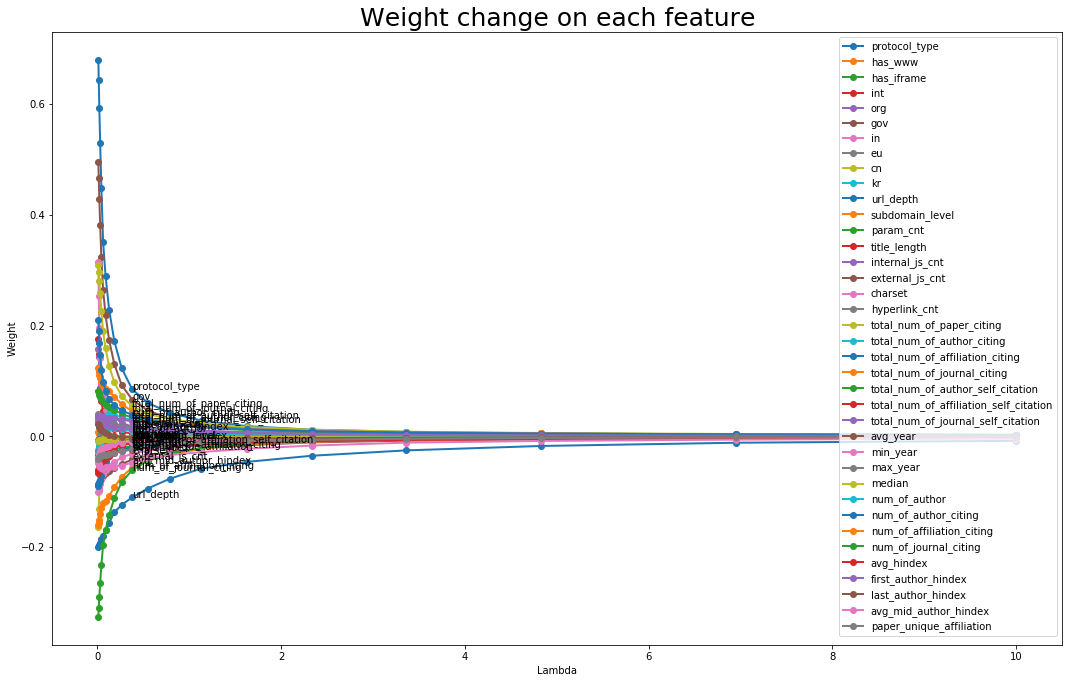

In [14]:
Visualizer.plot_importance_trending(X_train, performance_matrix, 'Weight change on each feature', 10)

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

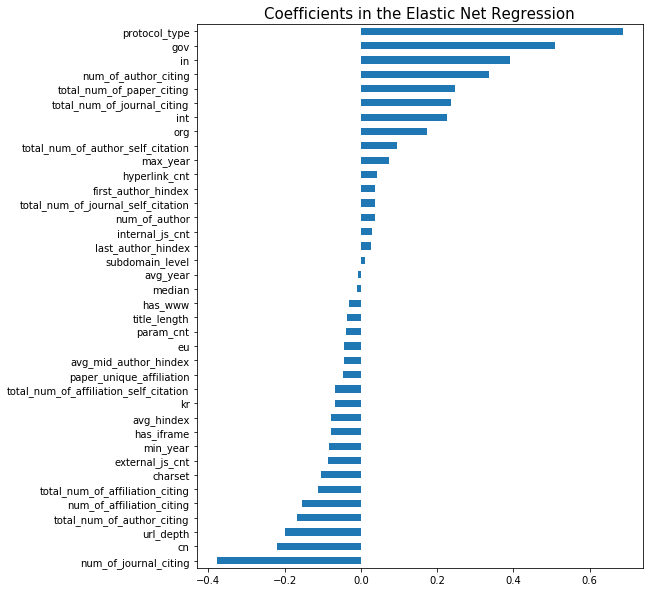

In [15]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train.columns, 
    "Coefficients in the Elastic Net Regression")

#### 2nd Edition - Lasso Regression to Select Features

In [16]:
from sklearn.linear_model import Lasso


start_time = time.time()
param_lso = {
    'alpha': sorted(np.logspace(-2, -1, 20)),
    'max_iter': np.arange(10,80,40),
}


lso = Lasso(random_state=seed)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_lso) \
    .set_engine(lso) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 00 minutes, 6.73 seconds ---


In [17]:
performance_matrix = build_visualization_matrix(result_train, result_test)

In [18]:
Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'mse', 'type', 'MSE Trending on Train/Test Set')


In [19]:
Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'r_2', 'type', 'Adjust R^2 Trending on Train/Test Set')


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 576x720 with 0 Axes>

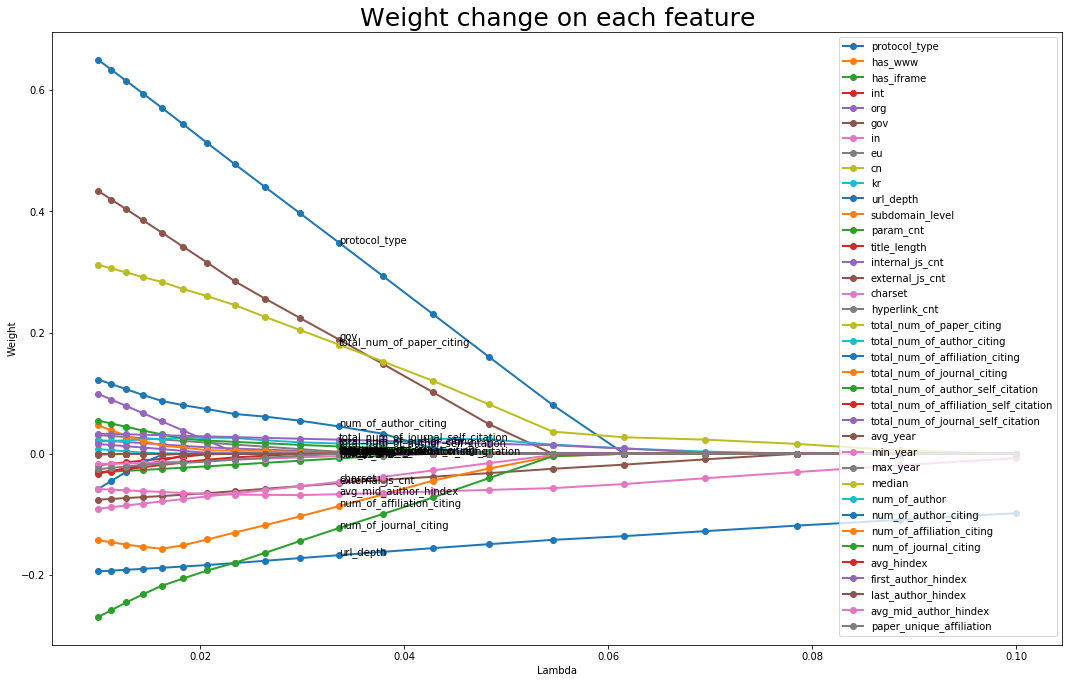

In [20]:
Visualizer.plot_importance_trending(X_train, performance_matrix, 'Weight change on each feature', 10)

In [21]:
start_time = time.time()
param_lso = {
    'alpha': [0.035],
    'max_iter': np.arange(10,80,40),
}


lso = Lasso(random_state=seed)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train) \
    .set_y_train(y_train) \
    .set_X_test(X_test) \
    .set_y_test(y_test) \
    .set_param_grid(param_lso) \
    .set_engine(lso) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 2.98%


Coefficients  Standard Errors  \
Constant                                      1.9566            0.117   
protocol_type                                 0.3310            0.089   
total_num_of_paper_citing                     0.1772            0.147   
gov                                           0.1753            0.078   
num_of_author_citing                          0.0565            0.143   
total_num_of_journal_self_citation            0.0222            0.026   
total_num_of_author_self_citation             0.0103            0.044   
hyperlink_cnt                                 0.0018            0.026   
internal_js_cnt                               0.0017            0.028   
has_iframe                                   -0.0000            0.081   
avg_year                                     -0.0000            2.809   
total_num_of_affiliation_self_citation       -0.0000            0.044   
median                                       -0.0000            0.025   
max_year                                     -0.0000            2.484   
int                                           0.0000            0.171   
num_of_author                                 0.0000            0.038   
avg_hindex                                   -0.0000            0.050   
first_author_hindex                           0.0000            0.032   
last_author_hindex                           -0.0000            0.037   
total_num_of_journal_citing                   0.0000            0.163   
total_num_of_affiliation_citing              -0.0000            0.129   
total_num_of_author_citing                    0.0000            0.141   
subdomain_level                              -0.0000            0.029   
org                                           0.0000            0.065   
in                                            0.0000            0.238   
eu                                           -0.0000            0.188   
cn                                           -0.0000            0.239   
has_www                                      -0.0000            0.057   
kr                                           -0.0000            0.557   
title_length                                 -0.0000            0.028   
paper_unique_affiliation                     -0.0000            0.036   
min_year                                     -0.0030            0.528   
param_cnt                                    -0.0062            0.025   
charset                                      -0.0438            0.027   
external_js_cnt                              -0.0467            0.027   
avg_mid_author_hindex                        -0.0656            0.034   
num_of_affiliation_citing                    -0.0786            0.107   
num_of_journal_citing                        -0.1217            0.068   
url_depth                                    -0.1654            0.027   

                                        t values  Probabilities  
Constant                                  16.767          0.000  
protocol_type                              3.728          0.000  
total_num_of_paper_citing                  1.207          0.227  
gov                                        2.258          0.024  
num_of_author_citing                       0.396          0.692  
total_num_of_journal_self_citation         0.843          0.399  
total_num_of_author_self_citation          0.235          0.814  
hyperlink_cnt                              0.069          0.945  
internal_js_cnt                            0.059          0.953  
has_iframe                                -0.000          1.000  
avg_year                                  -0.000          1.000  
total_num_of_affiliation_self_citation    -0.000          1.000  
median                                    -0.000          1.000  
max_year                                  -0.000          1.000  
int                                        0.000          1.000  
num_of_author                              0.000          1.000


R^2 on Testing Set: 2.31%


Coefficients  Standard Errors  \
Constant                                      1.9566            0.173   
protocol_type                                 0.3310            0.130   
total_num_of_paper_citing                     0.1772            0.298   
gov                                           0.1753            0.121   
num_of_author_citing                          0.0565            0.152   
total_num_of_journal_self_citation            0.0222            0.042   
total_num_of_author_self_citation             0.0103            0.072   
hyperlink_cnt                                 0.0018            0.040   
internal_js_cnt                               0.0017            0.043   
has_iframe                                   -0.0000            0.124   
avg_year                                     -0.0000            4.096   
total_num_of_affiliation_self_citation       -0.0000            0.081   
median                                       -0.0000            0.039   
max_year                                     -0.0000            3.613   
int                                           0.0000            0.263   
num_of_author                                 0.0000            0.077   
avg_hindex                                   -0.0000            0.076   
first_author_hindex                           0.0000            0.051   
last_author_hindex                           -0.0000            0.056   
total_num_of_journal_citing                   0.0000            0.312   
total_num_of_affiliation_citing              -0.0000            0.226   
total_num_of_author_citing                    0.0000            0.154   
subdomain_level                              -0.0000            0.044   
org                                           0.0000            0.099   
in                                            0.0000            0.409   
eu                                           -0.0000            0.307   
cn                                           -0.0000            0.383   
has_www                                      -0.0000            0.088   
kr                                           -0.0000            0.797   
title_length                                 -0.0000            0.043   
paper_unique_affiliation                     -0.0000            0.073   
min_year                                     -0.0030            0.758   
param_cnt                                    -0.0062            0.039   
charset                                      -0.0438            0.042   
external_js_cnt                              -0.0467            0.042   
avg_mid_author_hindex                        -0.0656            0.053   
num_of_affiliation_citing                    -0.0786            0.169   
num_of_journal_citing                        -0.1217            0.101   
url_depth                                    -0.1654            0.041   

                                        t values  Probabilities  
Constant                                  11.280          0.000  
protocol_type                              2.545          0.011  
total_num_of_paper_citing                  0.595          0.552  
gov                                        1.450          0.147  
num_of_author_citing                       0.373          0.709  
total_num_of_journal_self_citation         0.534          0.593  
total_num_of_author_self_citation          0.142          0.887  
hyperlink_cnt                              0.046          0.963  
internal_js_cnt                            0.039          0.969  
has_iframe                                -0.000          1.000  
avg_year                                  -0.000          1.000  
total_num_of_affiliation_self_citation    -0.000          1.000  
median                                    -0.000          1.000  
max_year                                  -0.000          1.000  
int                                        0.000          1.000  
num_of_author                              0.000          1.000

--- 00 minutes, 0.39 seconds ---


In [22]:
rpt = result_test.best_result.rpt


In [23]:
rpt[rpt.Coefficients == 0]

Coefficients  Standard Errors  \
has_iframe                                      -0.0            0.124   
avg_year                                        -0.0            4.096   
total_num_of_affiliation_self_citation          -0.0            0.081   
median                                          -0.0            0.039   
max_year                                        -0.0            3.613   
int                                              0.0            0.263   
num_of_author                                    0.0            0.077   
avg_hindex                                      -0.0            0.076   
first_author_hindex                              0.0            0.051   
last_author_hindex                              -0.0            0.056   
total_num_of_journal_citing                      0.0            0.312   
total_num_of_affiliation_citing                 -0.0            0.226   
total_num_of_author_citing                       0.0            0.154   
subdomain_level                                 -0.0            0.044   
org                                              0.0            0.099   
in                                               0.0            0.409   
eu                                              -0.0            0.307   
cn                                              -0.0            0.383   
has_www                                         -0.0            0.088   
kr                                              -0.0            0.797   
title_length                                    -0.0            0.043   
paper_unique_affiliation                        -0.0            0.073   

                                        t values  Probabilities  
has_iframe                                  -0.0            1.0  
avg_year                                    -0.0            1.0  
total_num_of_affiliation_self_citation      -0.0            1.0  
median                                      -0.0            1.0  
max_year                                    -0.0            1.0  
int                                          0.0            1.0  
num_of_author                                0.0            1.0  
avg_hindex                                  -0.0            1.0  
first_author_hindex                          0.0            1.0  
last_author_hindex                          -0.0            1.0  
total_num_of_journal_citing                  0.0            1.0  
total_num_of_affiliation_citing             -0.0            1.0  
total_num_of_author_citing                   0.0            1.0  
subdomain_level                             -0.0            1.0  
org                                          0.0            1.0  
in                                           0.0            1.0  
eu                                          -0.0            1.0  
cn                                          -0.0            1.0  
has_www                                     -0.0            1.0  
kr                                          -0.0            1.0  
title_length                                -0.0            1.0  
paper_unique_affiliation                    -0.0            1.0

In [24]:
rpt.sort_values(by=['Probabilities', 'Standard Errors'])

Coefficients  Standard Errors  \
url_depth                                    -0.1654            0.041   
Constant                                      1.9566            0.173   
protocol_type                                 0.3310            0.130   
gov                                           0.1753            0.121   
avg_mid_author_hindex                        -0.0656            0.053   
num_of_journal_citing                        -0.1217            0.101   
external_js_cnt                              -0.0467            0.042   
charset                                      -0.0438            0.042   
total_num_of_paper_citing                     0.1772            0.298   
total_num_of_journal_self_citation            0.0222            0.042   
num_of_affiliation_citing                    -0.0786            0.169   
num_of_author_citing                          0.0565            0.152   
param_cnt                                    -0.0062            0.039   
total_num_of_author_self_citation             0.0103            0.072   
hyperlink_cnt                                 0.0018            0.040   
internal_js_cnt                               0.0017            0.043   
min_year                                     -0.0030            0.758   
median                                       -0.0000            0.039   
title_length                                 -0.0000            0.043   
subdomain_level                              -0.0000            0.044   
first_author_hindex                           0.0000            0.051   
last_author_hindex                           -0.0000            0.056   
paper_unique_affiliation                     -0.0000            0.073   
avg_hindex                                   -0.0000            0.076   
num_of_author                                 0.0000            0.077   
total_num_of_affiliation_self_citation       -0.0000            0.081   
has_www                                      -0.0000            0.088   
org                                           0.0000            0.099   
has_iframe                                   -0.0000            0.124   
total_num_of_author_citing                    0.0000            0.154   
total_num_of_affiliation_citing              -0.0000            0.226   
int                                           0.0000            0.263   
eu                                           -0.0000            0.307   
total_num_of_journal_citing                   0.0000            0.312   
cn                                           -0.0000            0.383   
in                                            0.0000            0.409   
kr                                           -0.0000            0.797   
max_year                                     -0.0000            3.613   
avg_year                                     -0.0000            4.096   

                                        t values  Probabilities  
url_depth                                 -4.040          0.000  
Constant                                  11.280          0.000  
protocol_type                              2.545          0.011  
gov                                        1.450          0.147  
avg_mid_author_hindex                     -1.228          0.219  
num_of_journal_citing                     -1.202          0.229  
external_js_cnt                           -1.115          0.265  
charset                                   -1.035          0.301  
total_num_of_paper_citing                  0.595          0.552  
total_num_of_journal_self_citation         0.534          0.593  
num_of_affiliation_citing                 -0.465          0.642  
num_of_author_citing                       0.373          0.709  
param_cnt                                 -0.158          0.875  
total_num_of_author_self_citation          0.142          0.887  
hyperlink_cnt                              0.046          0.963  
internal_js_cnt                            0.039          0.969

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

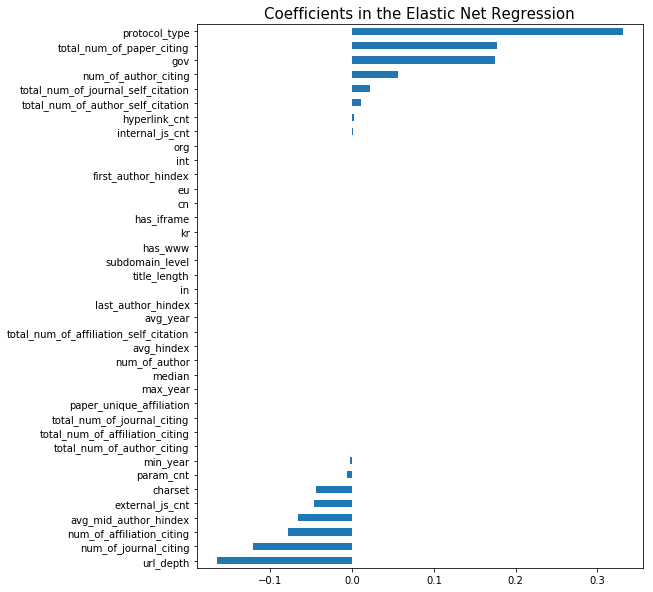

In [25]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train.columns, 
    "Coefficients in the Elastic Net Regression")

#### 3rd Edition - Use Selected Features to run Lasso Regression Again

- Manually select features

In [26]:
features = set(tuple([
    'org',
    'gov',
    'int',
    'in',
    'cn',
    'eu',
]))

for col_name in rpt[rpt.Coefficients != 0].index.tolist():
    features.add(col_name)

features.remove('Constant')

In [27]:
features

{'avg_mid_author_hindex',
 'charset',
 'cn',
 'eu',
 'external_js_cnt',
 'gov',
 'hyperlink_cnt',
 'in',
 'int',
 'internal_js_cnt',
 'min_year',
 'num_of_affiliation_citing',
 'num_of_author_citing',
 'num_of_journal_citing',
 'org',
 'param_cnt',
 'protocol_type',
 'total_num_of_author_self_citation',
 'total_num_of_journal_self_citation',
 'total_num_of_paper_citing',
 'url_depth'}

In [28]:
start_time = time.time()
param_lso = {
    'alpha': sorted(np.logspace(-2, -1, 20)),
    'max_iter': np.arange(10,80,40),
}


lso = Lasso(random_state=seed)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train[features]) \
    .set_y_train(y_train) \
    .set_X_test(X_test[features]) \
    .set_y_test(y_test) \
    .set_param_grid(param_lso) \
    .set_engine(lso) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 00 minutes, 5.37 seconds ---


In [29]:
performance_matrix = build_visualization_matrix(result_train, result_test)

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 576x720 with 0 Axes>

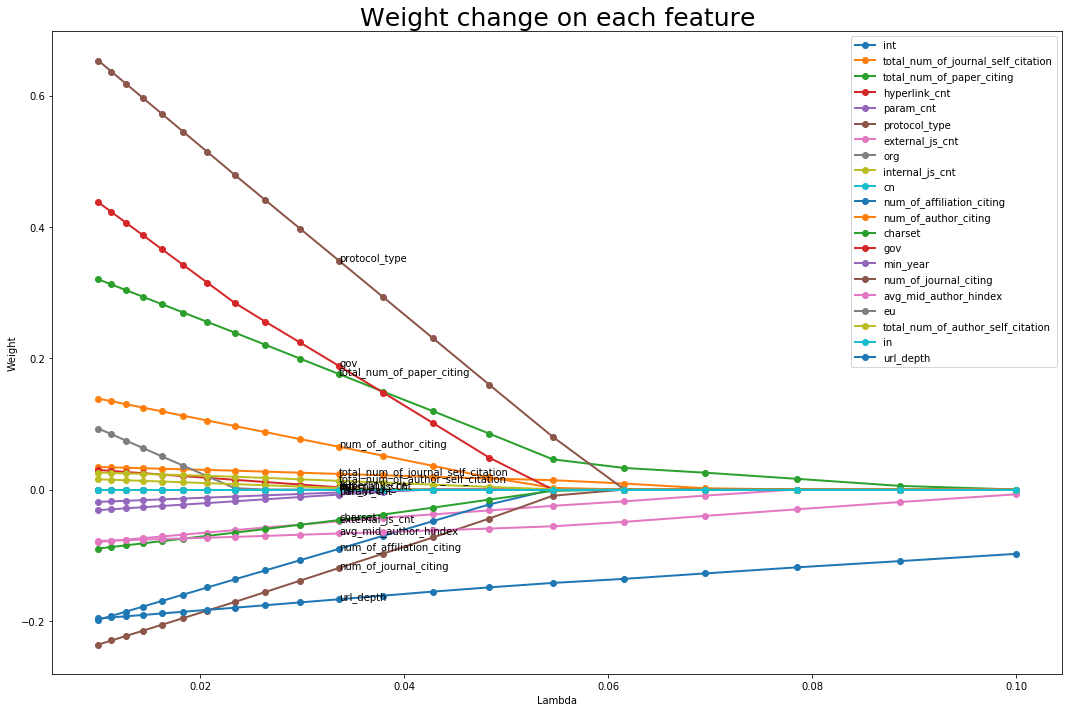

In [30]:
Visualizer.plot_importance_trending(X_train[features], performance_matrix, 'Weight change on each feature', 10)

In [31]:
start_time = time.time()
param_lso = {
    'alpha': [0.035],
    'max_iter': np.arange(10,80,40),
}


lso = Lasso(random_state=seed)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train[features]) \
    .set_y_train(y_train) \
    .set_X_test(X_test[features]) \
    .set_y_test(y_test) \
    .set_param_grid(param_lso) \
    .set_engine(lso) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 2.98%


Coefficients  Standard Errors  t values  \
Constant                                  1.9566            0.088    22.286   
protocol_type                             0.3310            0.088     3.756   
total_num_of_paper_citing                 0.1773            0.064     2.756   
gov                                       0.1753            0.077     2.292   
num_of_author_citing                      0.0564            0.050     1.121   
total_num_of_journal_self_citation        0.0222            0.026     0.854   
total_num_of_author_self_citation         0.0103            0.031     0.332   
hyperlink_cnt                             0.0018            0.026     0.070   
internal_js_cnt                           0.0017            0.026     0.065   
org                                       0.0000            0.059     0.000   
cn                                       -0.0000            0.237    -0.000   
int                                       0.0000            0.170     0.000   
in                                        0.0000            0.238     0.000   
eu                                       -0.0000            0.187    -0.000   
min_year                                 -0.0030            0.026    -0.116   
param_cnt                                -0.0062            0.025    -0.245   
charset                                  -0.0438            0.027    -1.620   
external_js_cnt                          -0.0467            0.027    -1.757   
avg_mid_author_hindex                    -0.0656            0.027    -2.438   
num_of_affiliation_citing                -0.0786            0.051    -1.527   
num_of_journal_citing                    -0.1217            0.057    -2.133   
url_depth                                -0.1654            0.026    -6.379   

                                    Probabilities  
Constant                                    0.000  
protocol_type                               0.000  
total_num_of_paper_citing                   0.006  
gov                                         0.022  
num_of_author_citing                        0.262  
total_num_of_journal_self_citation          0.393  
total_num_of_author_self_citation           0.740  
hyperlink_cnt                               0.944  
internal_js_cnt                             0.949  
org                                         1.000  
cn                                          1.000  
int                                         1.000  
in                                          1.000  
eu                                          1.000  
min_year                                    0.908  
param_cnt                                   0.807  
charset                                     0.105  
external_js_cnt                             0.079  
avg_mid_author_hindex                       0.015  
num_of_affiliation_citing                   0.127  
num_of_journal_citing                       0.033  
url_depth                                   0.000


R^2 on Testing Set: 2.31%


Coefficients  Standard Errors  t values  \
Constant                                  1.9566            0.129    15.219   
protocol_type                             0.3310            0.128     2.579   
total_num_of_paper_citing                 0.1773            0.095     1.871   
gov                                       0.1753            0.118     1.480   
num_of_author_citing                      0.0564            0.083     0.677   
total_num_of_journal_self_citation        0.0222            0.041     0.544   
total_num_of_author_self_citation         0.0103            0.050     0.205   
hyperlink_cnt                             0.0018            0.039     0.046   
internal_js_cnt                           0.0017            0.039     0.042   
org                                       0.0000            0.090     0.000   
cn                                       -0.0000            0.378    -0.000   
int                                       0.0000            0.260     0.000   
in                                        0.0000            0.407     0.000   
eu                                       -0.0000            0.305    -0.000   
min_year                                 -0.0030            0.039    -0.076   
param_cnt                                -0.0062            0.039    -0.159   
charset                                  -0.0438            0.042    -1.052   
external_js_cnt                          -0.0467            0.040    -1.155   
avg_mid_author_hindex                    -0.0656            0.041    -1.595   
num_of_affiliation_citing                -0.0786            0.086    -0.913   
num_of_journal_citing                    -0.1217            0.083    -1.473   
url_depth                                -0.1654            0.040    -4.131   

                                    Probabilities  
Constant                                    0.000  
protocol_type                               0.010  
total_num_of_paper_citing                   0.061  
gov                                         0.139  
num_of_author_citing                        0.498  
total_num_of_journal_self_citation          0.586  
total_num_of_author_self_citation           0.838  
hyperlink_cnt                               0.963  
internal_js_cnt                             0.966  
org                                         1.000  
cn                                          1.000  
int                                         1.000  
in                                          1.000  
eu                                          1.000  
min_year                                    0.939  
param_cnt                                   0.874  
charset                                     0.293  
external_js_cnt                             0.248  
avg_mid_author_hindex                       0.111  
num_of_affiliation_citing                   0.361  
num_of_journal_citing                       0.141  
url_depth                                   0.000

--- 00 minutes, 0.32 seconds ---


In [32]:
rpt = result_test.best_result.rpt


In [33]:
rpt[rpt.Coefficients == 0]

Coefficients  Standard Errors  t values  Probabilities
org           0.0            0.090       0.0            1.0
cn           -0.0            0.378      -0.0            1.0
int           0.0            0.260       0.0            1.0
in            0.0            0.407       0.0            1.0
eu           -0.0            0.305      -0.0            1.0

In [34]:
rpt.sort_values(by=['Probabilities', 'Standard Errors'])

Coefficients  Standard Errors  t values  \
url_depth                                -0.1654            0.040    -4.131   
Constant                                  1.9566            0.129    15.219   
protocol_type                             0.3310            0.128     2.579   
total_num_of_paper_citing                 0.1773            0.095     1.871   
avg_mid_author_hindex                    -0.0656            0.041    -1.595   
gov                                       0.1753            0.118     1.480   
num_of_journal_citing                    -0.1217            0.083    -1.473   
external_js_cnt                          -0.0467            0.040    -1.155   
charset                                  -0.0438            0.042    -1.052   
num_of_affiliation_citing                -0.0786            0.086    -0.913   
num_of_author_citing                      0.0564            0.083     0.677   
total_num_of_journal_self_citation        0.0222            0.041     0.544   
total_num_of_author_self_citation         0.0103            0.050     0.205   
param_cnt                                -0.0062            0.039    -0.159   
min_year                                 -0.0030            0.039    -0.076   
hyperlink_cnt                             0.0018            0.039     0.046   
internal_js_cnt                           0.0017            0.039     0.042   
org                                       0.0000            0.090     0.000   
int                                       0.0000            0.260     0.000   
eu                                       -0.0000            0.305    -0.000   
cn                                       -0.0000            0.378    -0.000   
in                                        0.0000            0.407     0.000   

                                    Probabilities  
url_depth                                   0.000  
Constant                                    0.000  
protocol_type                               0.010  
total_num_of_paper_citing                   0.061  
avg_mid_author_hindex                       0.111  
gov                                         0.139  
num_of_journal_citing                       0.141  
external_js_cnt                             0.248  
charset                                     0.293  
num_of_affiliation_citing                   0.361  
num_of_author_citing                        0.498  
total_num_of_journal_self_citation          0.586  
total_num_of_author_self_citation           0.838  
param_cnt                                   0.874  
min_year                                    0.939  
hyperlink_cnt                               0.963  
internal_js_cnt                             0.966  
org                                         1.000  
int                                         1.000  
eu                                          1.000  
cn                                          1.000  
in                                          1.000

<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

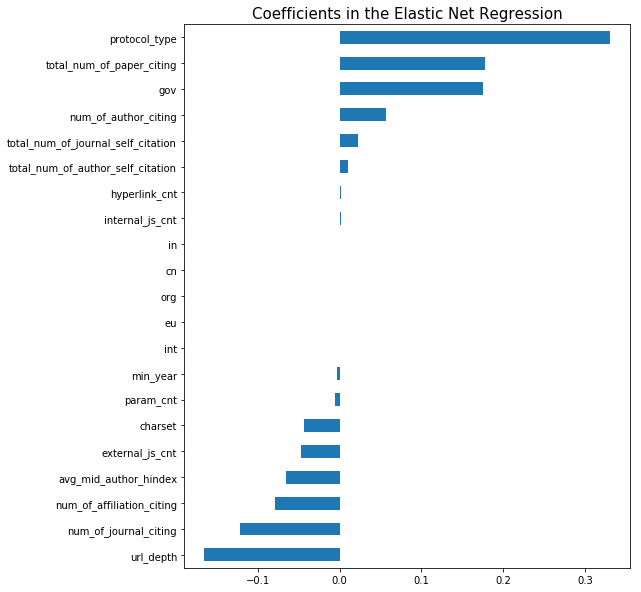

In [35]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train[features].columns, 
    "Coefficients in the Elastic Net Regression")

#### 4th Edition - Retrain the Elastic Net Regressor with Selected Features

In [36]:
features = rpt[rpt.Coefficients != 0].index.tolist()[1:]
features

['protocol_type',
 'total_num_of_paper_citing',
 'gov',
 'num_of_author_citing',
 'total_num_of_journal_self_citation',
 'total_num_of_author_self_citation',
 'hyperlink_cnt',
 'internal_js_cnt',
 'min_year',
 'param_cnt',
 'charset',
 'external_js_cnt',
 'avg_mid_author_hindex',
 'num_of_affiliation_citing',
 'num_of_journal_citing',
 'url_depth']

In [37]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train[features]) \
    .set_y_train(y_train) \
    .set_X_test(X_test[features]) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(VerboseGridSearchStrategy) \
    .build()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

--- 00 minutes, 30.07 seconds ---


In [38]:
performance_matrix = build_visualization_matrix(result_train, result_test)

In [39]:
Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'mse', 'type', 'MSE Trending on Train/Test Set')


In [40]:
Visualizer.plot_loss_trend(performance_matrix, 'alpha', 'r_2', 'type', 'Adjust R^2 Trending on Train/Test Set')


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 576x720 with 0 Axes>

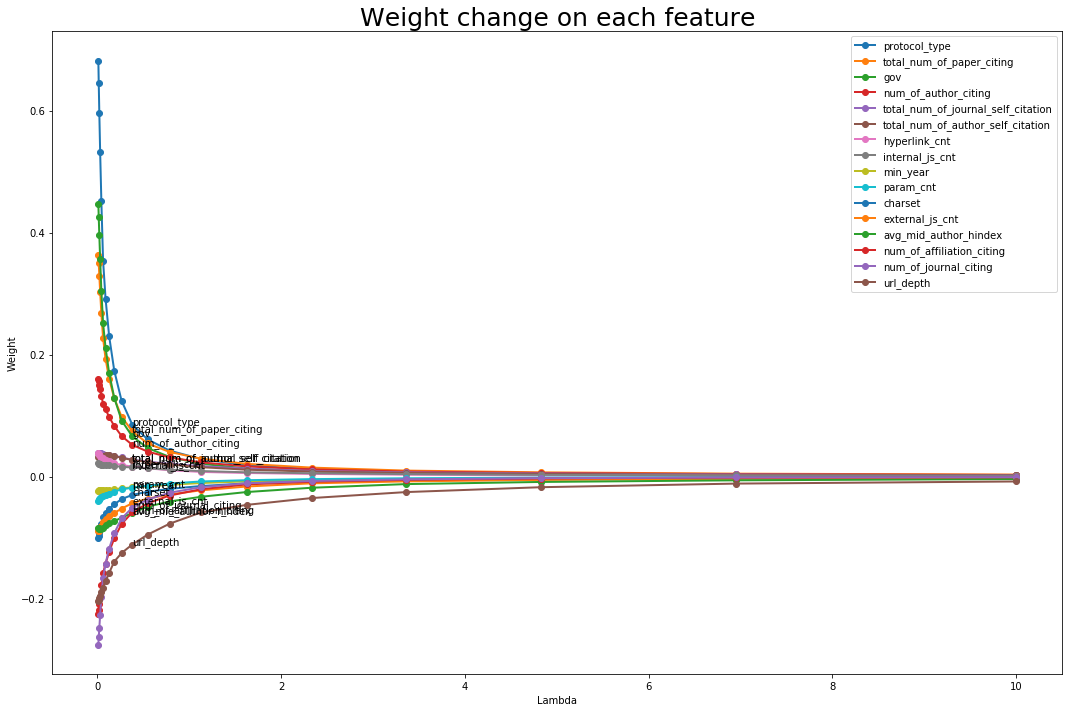

In [41]:
Visualizer.plot_importance_trending(X_train[features], performance_matrix, 'Weight change on each feature', 10)

In [42]:
start_time = time.time()
param_en = {
    'l1_ratio': [0, *np.logspace(-3, 0, 5)],
    'alpha': sorted(np.logspace(-2, 1, 20)),
    'max_iter': np.arange(10,80,40),
}


en = ElasticNet(random_state=seed,
                       warm_start=False,
)


# Start to train model
result_train, result_test = AnalysisEngineBuilder() \
    .set_X_train(X_train[features]) \
    .set_y_train(y_train) \
    .set_X_test(X_test[features]) \
    .set_y_test(y_test) \
    .set_param_grid(param_en) \
    .set_engine(en) \
    .set_train_strategy(GridSearchStrategy) \
    .build()

result_train.best_result.show_performance()
print()
result_test.best_result.show_performance()

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

R^2 on Training Set: 4.19%


Coefficients  Standard Errors  t values  \
Constant                                  1.5982            0.085    18.908   
protocol_type                             0.6829            0.087     7.812   
gov                                       0.4485            0.073     6.160   
total_num_of_paper_citing                 0.3570            0.064     5.592   
num_of_author_citing                      0.1672            0.050     3.349   
total_num_of_journal_self_citation        0.0394            0.026     1.529   
hyperlink_cnt                             0.0388            0.026     1.498   
total_num_of_author_self_citation         0.0328            0.031     1.064   
internal_js_cnt                           0.0215            0.026     0.838   
min_year                                 -0.0237            0.025    -0.932   
param_cnt                                -0.0397            0.025    -1.583   
avg_mid_author_hindex                    -0.0846            0.027    -3.167   
external_js_cnt                          -0.0901            0.026    -3.416   
charset                                  -0.1018            0.027    -3.788   
url_depth                                -0.2047            0.026    -8.022   
num_of_affiliation_citing                -0.2334            0.051    -4.564   
num_of_journal_citing                    -0.2688            0.057    -4.747   

                                    Probabilities  
Constant                                    0.000  
protocol_type                               0.000  
gov                                         0.000  
total_num_of_paper_citing                   0.000  
num_of_author_citing                        0.001  
total_num_of_journal_self_citation          0.126  
hyperlink_cnt                               0.134  
total_num_of_author_self_citation           0.287  
internal_js_cnt                             0.402  
min_year                                    0.351  
param_cnt                                   0.114  
avg_mid_author_hindex                       0.002  
external_js_cnt                             0.001  
charset                                     0.000  
url_depth                                   0.000  
num_of_affiliation_citing                   0.000  
num_of_journal_citing                       0.000


R^2 on Testing Set: 2.68%


Coefficients  Standard Errors  t values  \
Constant                                  1.5982            0.123    12.979   
protocol_type                             0.6829            0.128     5.344   
gov                                       0.4485            0.113     3.959   
total_num_of_paper_citing                 0.3570            0.094     3.780   
num_of_author_citing                      0.1672            0.083     2.015   
total_num_of_journal_self_citation        0.0394            0.041     0.970   
hyperlink_cnt                             0.0388            0.039     0.991   
total_num_of_author_self_citation         0.0328            0.050     0.655   
internal_js_cnt                           0.0215            0.039     0.547   
min_year                                 -0.0237            0.039    -0.607   
param_cnt                                -0.0397            0.039    -1.026   
avg_mid_author_hindex                    -0.0846            0.041    -2.064   
external_js_cnt                          -0.0901            0.040    -2.236   
charset                                  -0.1018            0.041    -2.454   
url_depth                                -0.2047            0.039    -5.185   
num_of_affiliation_citing                -0.2334            0.086    -2.722   
num_of_journal_citing                    -0.2688            0.082    -3.265   

                                    Probabilities  
Constant                                    0.000  
protocol_type                               0.000  
gov                                         0.000  
total_num_of_paper_citing                   0.000  
num_of_author_citing                        0.044  
total_num_of_journal_self_citation          0.332  
hyperlink_cnt                               0.322  
total_num_of_author_self_citation           0.513  
internal_js_cnt                             0.584  
min_year                                    0.544  
param_cnt                                   0.305  
avg_mid_author_hindex                       0.039  
external_js_cnt                             0.025  
charset                                     0.014  
url_depth                                   0.000  
num_of_affiliation_citing                   0.007  
num_of_journal_citing                       0.001

--- 00 minutes, 23.77 seconds ---


<module 'matplotlib.pyplot' from '/home/jjian03/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

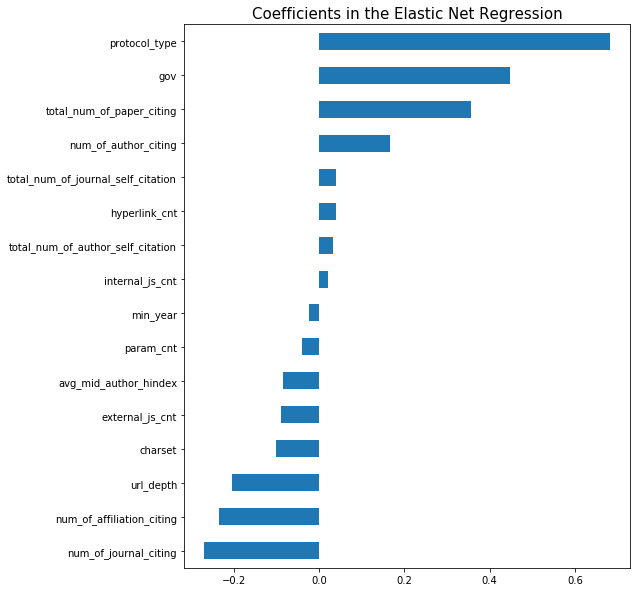

In [43]:
Visualizer.plot_feature_importance(
    result_train.best_result.model.coef_, X_train[features].columns, 
    "Coefficients in the Elastic Net Regression")